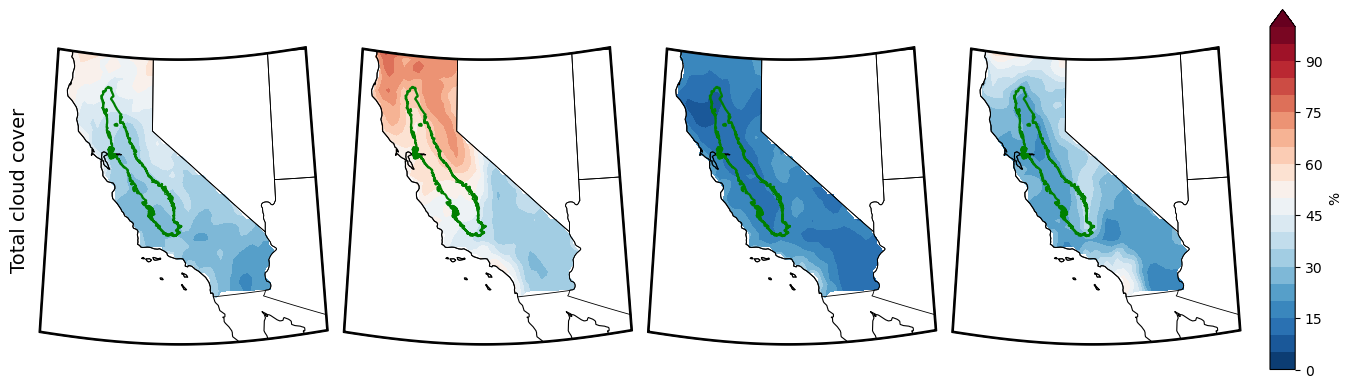

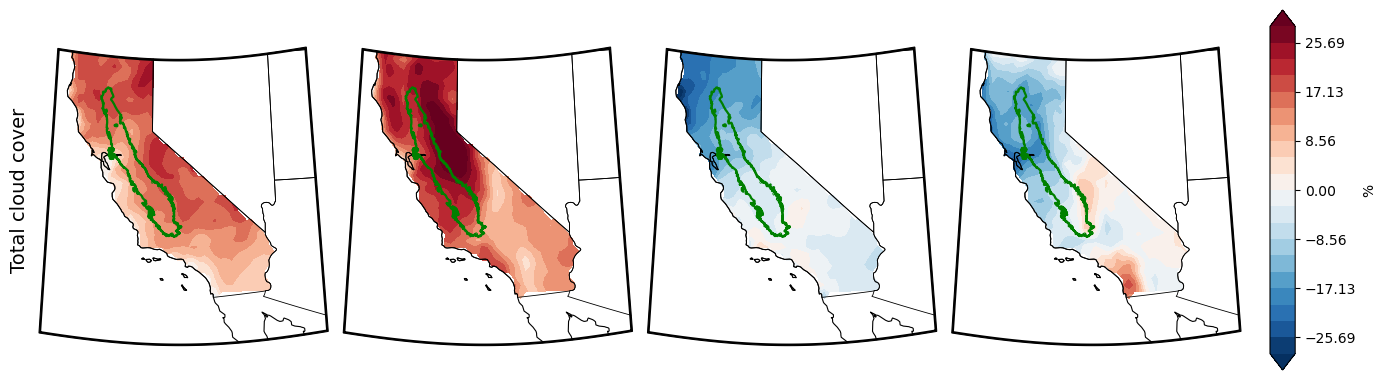

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Z500 SOM → Node-conditioned Total Cloud Cover (TCC) composites.
- Train SOM on Z500 (SON season)
- Compute TCC mean per node
- Compute TCC anomaly per node (Node mean − matched climatology)
- Plot nodes ordered by frequency
"""

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu
import regionmask

# ======================= USER INPUTS =======================
Z500_FILE     = "z_dust1.nc"          # Z500 field (var 'gh')
TCC_COMP_FILE = "son_cloud_dust.nc"   # SON composite days
TCC_CLIM_FILE = "clim.nc"             # SON climatology (dummy SON year)
CV_SHP        = "central_valley_alluvial_boundary_usgs.shp"

OUT_MEAN = "node_tcc_mean.png"
OUT_ANOM = "node_tcc_anom.png"

# SOM training window for Z500
LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

# California plotting frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# ======================= HELPERS =======================
def detect_time(ds):
    for t in ["date", "time"]:
        if t in ds.coords or t in ds.dims:
            return t
    raise KeyError("No 'valid_time' or 'time' found.")

def rename_latlon(da):
    ren = {}
    if "lat" in da.dims: ren["lat"] = "latitude"
    if "lon" in da.dims: ren["lon"] = "longitude"
    return da.rename(ren) if ren else da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude + 180) % 360) - 180).sortby("longitude")
    return da

def first_var(ds, preferred=("tcc","clt","cloud","total_cloud_cover")):
    for k in preferred:
        if k in ds.data_vars: return k
    return list(ds.data_vars)[0]

def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def mask_to_california(da):
    ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                        name="admin_1_states_provinces")
    states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
    ca_poly = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry.union_all()
    ca_gdf = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")
    mask = regionmask.mask_geopandas(ca_gdf, da.longitude, da.latitude)
    return da.where(~np.isnan(mask))

# ======================= 1) Train SOM on Z500 =======================
ds_z = xr.open_dataset(Z500_FILE)
t_z  = detect_time(ds_z)

z = ds_z["z"]
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

z = rename_latlon(fix_lon(z))
z_son = z.sel({t_z: z[t_z].dt.month.isin([9,10,11])})
z_son = (z_son
         .where((z_son.latitude >= LAT0) & (z_son.latitude <= LAT1), drop=True)
         .where((z_son.longitude>= LON0) & (z_son.longitude<= LON1), drop=True))

data = z_son.values
ntime, nlat, nlon = data.shape
flat = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]    # 0..3
times_all  = z_son[t_z].values
freqs      = np.array([(labels_all==n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs)

# ======================= 2) Load TCC + climatology =======================
ds_tc  = xr.open_dataset(TCC_COMP_FILE)
ds_cl  = xr.open_dataset(TCC_CLIM_FILE)

VTCC = first_var(ds_tc)
VCLM = first_var(ds_cl)

tcc   = rename_latlon(fix_lon(ds_tc[VTCC]))
clim  = rename_latlon(fix_lon(ds_cl[VCLM]))

t_tcc = detect_time(ds_tc)
tcc  = tcc.transpose(t_tcc, "latitude", "longitude")
clim = clim.transpose("time",  "latitude", "longitude")

# Align grids
clim, tcc = xr.align(clim, tcc, join="inner")

# Match times with Z500 labels
t_vals = tcc[t_tcc].values
_, idx_tcc, idx_z = np.intersect1d(t_vals, times_all, return_indices=True)
tcc    = tcc.isel({t_tcc: idx_tcc})
labels = labels_all[idx_z]

# Month-day climatology
md_tcc   = tcc[t_tcc].dt.strftime("%m-%d").values
md_coord = xr.DataArray(clim["time"].dt.strftime("%m-%d").values, dims=["time"], name="md")
clim_by_md = clim.groupby(md_coord).mean("time")

# ======================= 3) Per-node mean & anomaly =======================
node_mean, node_anom = {}, {}

for n in range(4):
    sel = (labels == n)
    if not sel.any():
        proto = tcc.isel({t_tcc: 0}).drop_vars(t_tcc)
        node_mean[n] = xr.full_like(proto, np.nan)
        node_anom[n] = xr.full_like(proto, np.nan)
        continue

    tcc_n = tcc.isel({t_tcc: sel})
    md_n  = md_tcc[sel]

    mean_n      = tcc_n.mean(dim=t_tcc, skipna=True)
    clim_mean_n = clim_by_md.sel(md=md_n).mean(dim="md", skipna=True)

    # convert to %
    if (float(mean_n.min()) >= 0 and float(mean_n.max()) <= 1):
        mean_n *= 100.0
        clim_mean_n *= 100.0
        mean_n.attrs["units"] = "%"

    anom_n = mean_n - clim_mean_n
    anom_n.attrs["units"] = "%"

    node_mean[n] = mean_n
    node_anom[n] = anom_n

# reorder by frequency
mean_sorted = [mask_to_california(node_mean[i]) for i in order]
anom_sorted = [mask_to_california(node_anom[i]) for i in order]
freq_sorted = [freqs[i] for i in order]
cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)

# ======================= 4) Plotting =======================
def plot_fields(fields, title, out_png, units_label, is_anom=False):
    proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                                 standard_parallels=(33,45))
    box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)

    fig, axes = plt.subplots(1, 4, figsize=(14,6), subplot_kw={"projection": proj})
    plt.tight_layout(rect=[0.06, 0.0, 0.94, 1.0])

    if is_anom:
        cmap = mpl.colormaps["RdBu_r"].copy()  # bottom red, top blue
        arr = np.stack([f.values for f in fields], axis=0)
        rob  = np.nanpercentile(np.abs(arr), 98)
        vlim = max(float(rob), 1.0)
        levels = np.linspace(-vlim, vlim, 21)
        extend = "both"
    else:
        cmap = mpl.colormaps["RdBu_r"].copy()
        levels = np.linspace(0, 100, 21)
        extend = "max"

    cmap.set_bad(cmap(0))
    cmap.set_under(cmap(0))
    #cmap.set_over(cmap(-1))

    lon2d, lat2d = np.meshgrid(fields[0].longitude, fields[0].latitude)
    cf_last = None
    for i, ax in enumerate(axes):
        clip_to_path(ax, box_path, linewidth=3)
        ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

        field = np.ma.masked_invalid(fields[i].values)
        cf_last = ax.contourf(lon2d, lat2d, field, levels=levels,
                              transform=ccrs.PlateCarree(),
                              cmap=cmap, extend=extend)

        ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
        ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.6, zorder=6)
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
        #ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=14, pad=3)

    fig.supylabel(title, x=0.05, fontsize=14)
    cax = fig.add_axes([0.95, 0.20, 0.018, 0.60])
    cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
    cb.set_label(units_label)
    fig.savefig(out_png, dpi=500, bbox_inches="tight")
    plt.show()

# ======================= 5) Run plots =======================
plot_fields(mean_sorted, "Total cloud cover", OUT_MEAN,
            units_label=mean_sorted[0].attrs.get("units","%"), is_anom=False)
plot_fields(anom_sorted, "Total cloud cover", OUT_ANOM,
            units_label=anom_sorted[0].attrs.get("units","%"), is_anom=True)


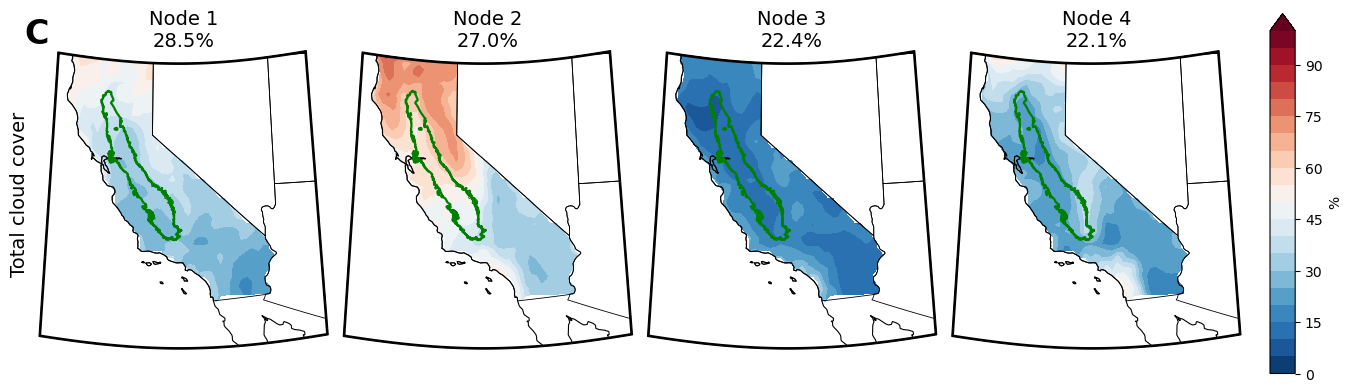

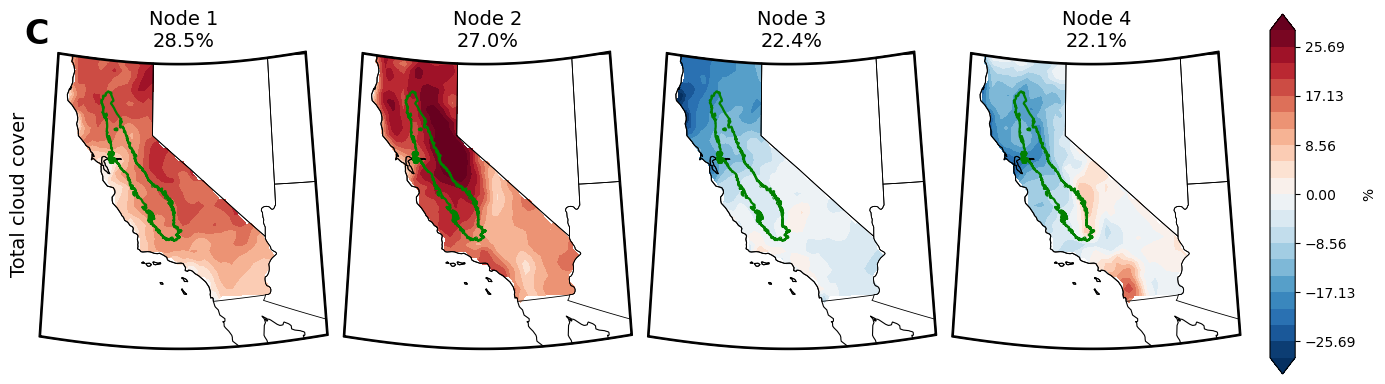

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu
import regionmask

# ======================= USER INPUTS =======================
Z500_FILE     = "z_dust1.nc"          # Z500 field (var 'gh')
TCC_COMP_FILE = "son_cloud_dust.nc"   # SON composite days
TCC_CLIM_FILE = "clim.nc"             # SON climatology (dummy SON year)
CV_SHP        = "central_valley_alluvial_boundary_usgs.shp"

OUT_MEAN = "tcc_mean.png"
OUT_ANOM = "tcc_anom.png"

# SOM training window for Z500
LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

# California plotting frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# ======================= HELPERS =======================
def detect_time(ds):
    for t in ["date", "time"]:
        if t in ds.coords or t in ds.dims:
            return t
    raise KeyError("No 'valid_time' or 'time' found.")

def rename_latlon(da):
    ren = {}
    if "lat" in da.dims: ren["lat"] = "latitude"
    if "lon" in da.dims: ren["lon"] = "longitude"
    return da.rename(ren) if ren else da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude + 180) % 360) - 180).sortby("longitude")
    return da

def first_var(ds, preferred=("tcc","clt","cloud","total_cloud_cover")):
    for k in preferred:
        if k in ds.data_vars: return k
    return list(ds.data_vars)[0]

def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def mask_to_california(da):
    ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                        name="admin_1_states_provinces")
    states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
    ca_poly = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry.union_all()
    ca_gdf = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")
    mask = regionmask.mask_geopandas(ca_gdf, da.longitude, da.latitude)
    return da.where(~np.isnan(mask))

# ======================= 1) Train SOM on Z500 =======================
ds_z = xr.open_dataset(Z500_FILE)
t_z  = detect_time(ds_z)

z = ds_z["z"]
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

z = rename_latlon(fix_lon(z))
z_son = z.sel({t_z: z[t_z].dt.month.isin([9,10,11])})
z_son = (z_son
         .where((z_son.latitude >= LAT0) & (z_son.latitude <= LAT1), drop=True)
         .where((z_son.longitude>= LON0) & (z_son.longitude<= LON1), drop=True))

data = z_son.values
ntime, nlat, nlon = data.shape
flat = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(777)
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]    # 0..3
times_all  = z_son[t_z].values
freqs      = np.array([(labels_all==n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs)

# ======================= 2) Load TCC + climatology =======================
ds_tc  = xr.open_dataset(TCC_COMP_FILE)
ds_cl  = xr.open_dataset(TCC_CLIM_FILE)

VTCC = first_var(ds_tc)
VCLM = first_var(ds_cl)

tcc   = rename_latlon(fix_lon(ds_tc[VTCC]))
clim  = rename_latlon(fix_lon(ds_cl[VCLM]))

t_tcc = detect_time(ds_tc)
tcc  = tcc.transpose(t_tcc, "latitude", "longitude")
clim = clim.transpose("time",  "latitude", "longitude")

# Align grids
clim, tcc = xr.align(clim, tcc, join="inner")

# Match times with Z500 labels
t_vals = tcc[t_tcc].values
_, idx_tcc, idx_z = np.intersect1d(t_vals, times_all, return_indices=True)
tcc    = tcc.isel({t_tcc: idx_tcc})
labels = labels_all[idx_z]

# Month-day climatology
md_tcc   = tcc[t_tcc].dt.strftime("%m-%d").values
md_coord = xr.DataArray(clim["time"].dt.strftime("%m-%d").values, dims=["time"], name="md")
clim_by_md = clim.groupby(md_coord).mean("time")

# ======================= 3) Per-node mean & anomaly =======================
node_mean, node_anom = {}, {}

for n in range(4):
    sel = (labels == n)
    if not sel.any():
        proto = tcc.isel({t_tcc: 0}).drop_vars(t_tcc)
        node_mean[n] = xr.full_like(proto, np.nan)
        node_anom[n] = xr.full_like(proto, np.nan)
        continue

    tcc_n = tcc.isel({t_tcc: sel})
    md_n  = md_tcc[sel]

    mean_n      = tcc_n.mean(dim=t_tcc, skipna=True)
    clim_mean_n = clim_by_md.sel(md=md_n).mean(dim="md", skipna=True)

    # convert to %
    if (float(mean_n.min()) >= 0 and float(mean_n.max()) <= 1):
        mean_n *= 100.0
        clim_mean_n *= 100.0
        mean_n.attrs["units"] = "%"

    anom_n = mean_n - clim_mean_n
    anom_n.attrs["units"] = "%"

    node_mean[n] = mean_n
    node_anom[n] = anom_n

# reorder by frequency
mean_sorted = [mask_to_california(node_mean[i]) for i in order]
anom_sorted = [mask_to_california(node_anom[i]) for i in order]
freq_sorted = [freqs[i] for i in order]
cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)

# ======================= 4) Plotting =======================
def plot_fields(fields, title, out_png, units_label, is_anom=False):
    proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                                 standard_parallels=(33,45))
    box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)

    fig, axes = plt.subplots(1, 4, figsize=(14,6), subplot_kw={"projection": proj})
    plt.tight_layout(rect=[0.06, 0.0, 0.94, 1.0])

    if is_anom:
        cmap = mpl.colormaps["RdBu_r"].copy()  # bottom red, top blue
        arr = np.stack([f.values for f in fields], axis=0)
        rob  = np.nanpercentile(np.abs(arr), 98)
        vlim = max(float(rob), 1.0)
        levels = np.linspace(-vlim, vlim, 21)
        extend = "both"
    else:
        cmap = mpl.colormaps["RdBu_r"].copy()
        levels = np.linspace(0, 100, 21)
        extend = "max"

    cmap.set_bad(cmap(0))
    cmap.set_under(cmap(0))
    #cmap.set_over(cmap(-1))

    lon2d, lat2d = np.meshgrid(fields[0].longitude, fields[0].latitude)
    cf_last = None
    for i, ax in enumerate(axes):
        clip_to_path(ax, box_path, linewidth=3)
        ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

        field = np.ma.masked_invalid(fields[i].values)
        cf_last = ax.contourf(lon2d, lat2d, field, levels=levels,
                              transform=ccrs.PlateCarree(),
                              cmap=cmap, extend=extend)

        ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
        ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.6, zorder=6)
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
        ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=14, pad=3)


    ax0=axes.flat[0]
    
    b = ax0.get_position()
    fig.text(0.06, b.y1,"C", ha="left",va="bottom", fontsize=24,fontweight="bold",
             fontfamily="sans-serif",transform=fig.transFigure)

    fig.supylabel(title, x=0.05, fontsize=14)
    cax = fig.add_axes([0.95, 0.20, 0.018, 0.60])
    cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
    cb.set_label(units_label)
    fig.savefig(out_png, dpi=500, bbox_inches="tight")
    plt.show()

# ======================= 5) Run plots =======================
plot_fields(mean_sorted, "Total cloud cover", OUT_MEAN,
            units_label=mean_sorted[0].attrs.get("units","%"), is_anom=False)
plot_fields(anom_sorted, "Total cloud cover", OUT_ANOM,
            units_label=anom_sorted[0].attrs.get("units","%"), is_anom=True)


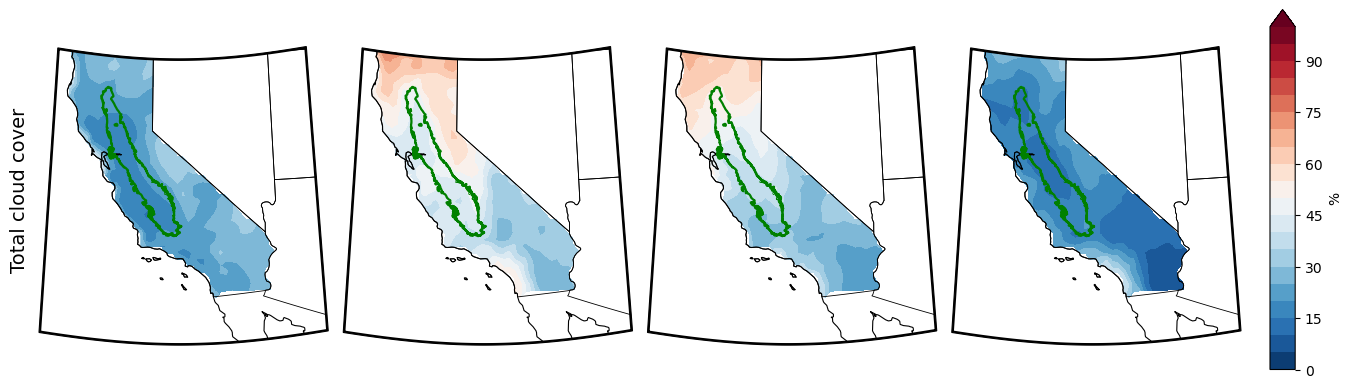

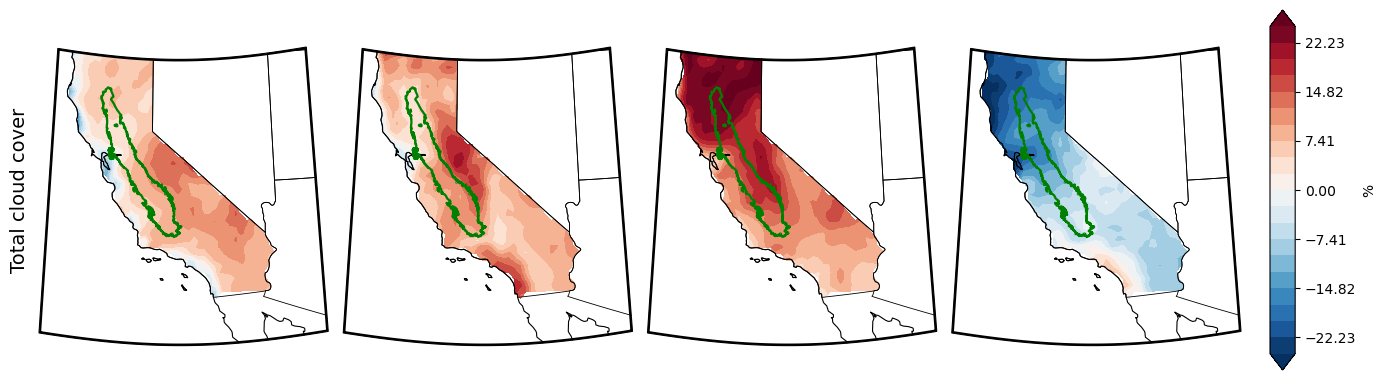

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Z500 SOM → Node-conditioned Total Cloud Cover (TCC) composites.
- Train SOM on Z500 (SON season)
- Compute TCC mean per node
- Compute TCC anomaly per node (Node mean − matched climatology)
- Plot nodes ordered by frequency
"""

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu
import regionmask

# ======================= USER INPUTS =======================
Z500_FILE     = "z_dust1.nc"          # Z500 field (var 'gh')
TCC_COMP_FILE = "ason_cloud_dust.nc"   # SON composite days
TCC_CLIM_FILE = "ason_clim.nc"             # SON climatology (dummy SON year)
CV_SHP        = "central_valley_alluvial_boundary_usgs.shp"

OUT_MEAN = "ason_node_tcc_mean.png"
OUT_ANOM = "ason_node_tcc_anom.png"

# SOM training window for Z500
LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

# California plotting frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# ======================= HELPERS =======================
def detect_time(ds):
    for t in ["date", "time"]:
        if t in ds.coords or t in ds.dims:
            return t
    raise KeyError("No 'valid_time' or 'time' found.")

def rename_latlon(da):
    ren = {}
    if "lat" in da.dims: ren["lat"] = "latitude"
    if "lon" in da.dims: ren["lon"] = "longitude"
    return da.rename(ren) if ren else da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude + 180) % 360) - 180).sortby("longitude")
    return da

def first_var(ds, preferred=("tcc","clt","cloud","total_cloud_cover")):
    for k in preferred:
        if k in ds.data_vars: return k
    return list(ds.data_vars)[0]

def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def mask_to_california(da):
    ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                        name="admin_1_states_provinces")
    states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
    ca_poly = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry.union_all()
    ca_gdf = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")
    mask = regionmask.mask_geopandas(ca_gdf, da.longitude, da.latitude)
    return da.where(~np.isnan(mask))

# ======================= 1) Train SOM on Z500 =======================
ds_z = xr.open_dataset(Z500_FILE)
t_z  = detect_time(ds_z)

z = ds_z["z"]
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

z = rename_latlon(fix_lon(z))
z_son = z.sel({t_z: z[t_z].dt.month.isin([8,9,10,11])})
z_son = (z_son
         .where((z_son.latitude >= LAT0) & (z_son.latitude <= LAT1), drop=True)
         .where((z_son.longitude>= LON0) & (z_son.longitude<= LON1), drop=True))

data = z_son.values
ntime, nlat, nlon = data.shape
flat = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]    # 0..3
times_all  = z_son[t_z].values
freqs      = np.array([(labels_all==n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs)

# ======================= 2) Load TCC + climatology =======================
ds_tc  = xr.open_dataset(TCC_COMP_FILE)
ds_cl  = xr.open_dataset(TCC_CLIM_FILE)

VTCC = first_var(ds_tc)
VCLM = first_var(ds_cl)

tcc   = rename_latlon(fix_lon(ds_tc[VTCC]))
clim  = rename_latlon(fix_lon(ds_cl[VCLM]))

t_tcc = detect_time(ds_tc)
tcc  = tcc.transpose(t_tcc, "latitude", "longitude")
clim = clim.transpose("time",  "latitude", "longitude")

# Align grids
clim, tcc = xr.align(clim, tcc, join="inner")

# Match times with Z500 labels
t_vals = tcc[t_tcc].values
_, idx_tcc, idx_z = np.intersect1d(t_vals, times_all, return_indices=True)
tcc    = tcc.isel({t_tcc: idx_tcc})
labels = labels_all[idx_z]

# Month-day climatology
md_tcc   = tcc[t_tcc].dt.strftime("%m-%d").values
md_coord = xr.DataArray(clim["time"].dt.strftime("%m-%d").values, dims=["time"], name="md")
clim_by_md = clim.groupby(md_coord).mean("time")

# ======================= 3) Per-node mean & anomaly =======================
node_mean, node_anom = {}, {}

for n in range(4):
    sel = (labels == n)
    if not sel.any():
        proto = tcc.isel({t_tcc: 0}).drop_vars(t_tcc)
        node_mean[n] = xr.full_like(proto, np.nan)
        node_anom[n] = xr.full_like(proto, np.nan)
        continue

    tcc_n = tcc.isel({t_tcc: sel})
    md_n  = md_tcc[sel]

    mean_n      = tcc_n.mean(dim=t_tcc, skipna=True)
    clim_mean_n = clim_by_md.sel(md=md_n).mean(dim="md", skipna=True)

    # convert to %
    if (float(mean_n.min()) >= 0 and float(mean_n.max()) <= 1):
        mean_n *= 100.0
        clim_mean_n *= 100.0
        mean_n.attrs["units"] = "%"

    anom_n = mean_n - clim_mean_n
    anom_n.attrs["units"] = "%"

    node_mean[n] = mean_n
    node_anom[n] = anom_n

# reorder by frequency
mean_sorted = [mask_to_california(node_mean[i]) for i in order]
anom_sorted = [mask_to_california(node_anom[i]) for i in order]
freq_sorted = [freqs[i] for i in order]
cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)

# ======================= 4) Plotting =======================
def plot_fields(fields, title, out_png, units_label, is_anom=False):
    proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                                 standard_parallels=(33,45))
    box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)

    fig, axes = plt.subplots(1, 4, figsize=(14,6), subplot_kw={"projection": proj})
    plt.tight_layout(rect=[0.06, 0.0, 0.94, 1.0])

    if is_anom:
        cmap = mpl.colormaps["RdBu_r"].copy()  # bottom red, top blue
        arr = np.stack([f.values for f in fields], axis=0)
        rob  = np.nanpercentile(np.abs(arr), 98)
        vlim = max(float(rob), 1.0)
        levels = np.linspace(-vlim, vlim, 21)
        extend = "both"
    else:
        cmap = mpl.colormaps["RdBu_r"].copy()
        levels = np.linspace(0, 100, 21)
        extend = "max"

    cmap.set_bad(cmap(0))
    cmap.set_under(cmap(0))
    #cmap.set_over(cmap(-1))

    lon2d, lat2d = np.meshgrid(fields[0].longitude, fields[0].latitude)
    cf_last = None
    for i, ax in enumerate(axes):
        clip_to_path(ax, box_path, linewidth=3)
        ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

        field = np.ma.masked_invalid(fields[i].values)
        cf_last = ax.contourf(lon2d, lat2d, field, levels=levels,
                              transform=ccrs.PlateCarree(),
                              cmap=cmap, extend=extend)

        ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
        ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.6, zorder=6)
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
        #ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=14, pad=3)

    fig.supylabel(title, x=0.05, fontsize=14)
    cax = fig.add_axes([0.95, 0.20, 0.018, 0.60])
    cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
    cb.set_label(units_label)
    fig.savefig(out_png, dpi=500, bbox_inches="tight")
    plt.show()

# ======================= 5) Run plots =======================
plot_fields(mean_sorted, "Total cloud cover", OUT_MEAN,
            units_label=mean_sorted[0].attrs.get("units","%"), is_anom=False)
plot_fields(anom_sorted, "Total cloud cover", OUT_ANOM,
            units_label=anom_sorted[0].attrs.get("units","%"), is_anom=True)


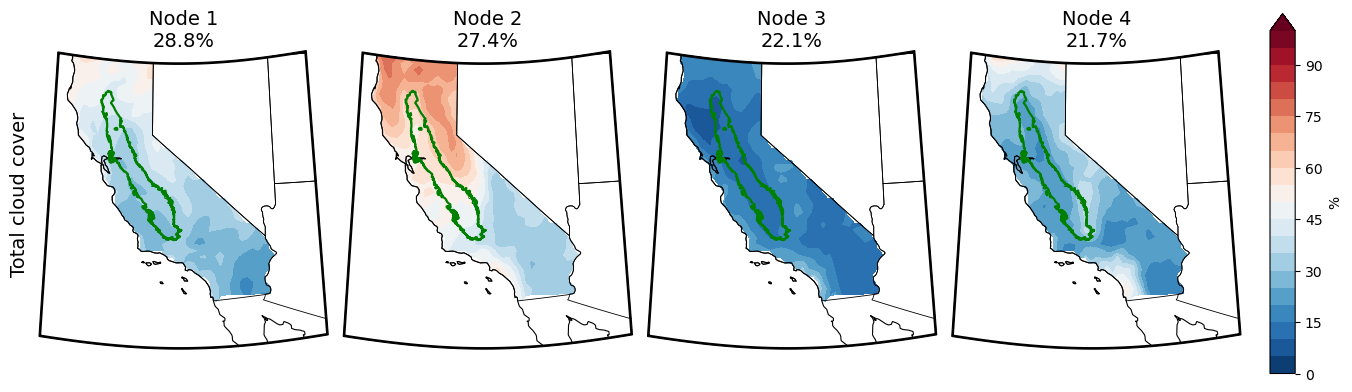

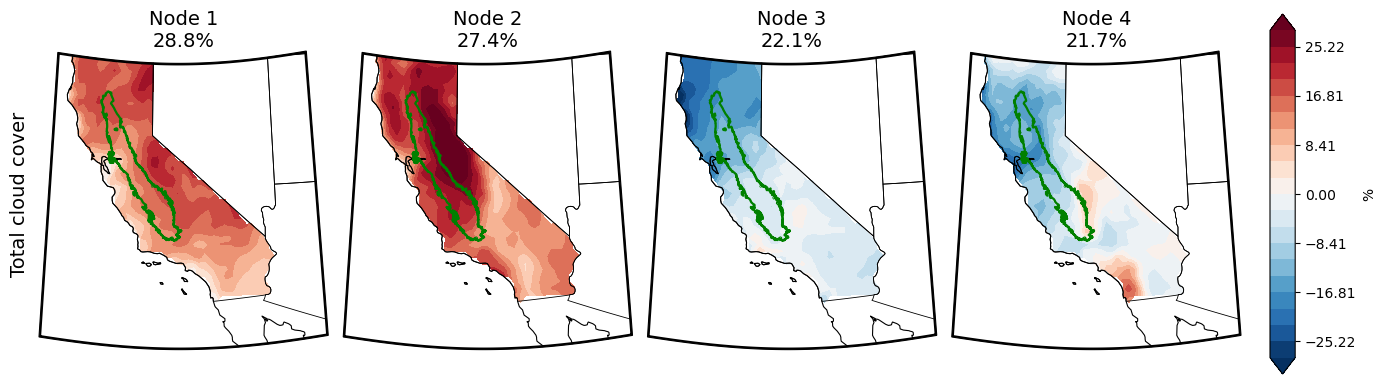

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Z500 SOM → Node-conditioned Total Cloud Cover (TCC) composites.
- Train SOM on Z500 (SON season)
- Compute TCC mean per node
- Compute TCC anomaly per node (Node mean − matched climatology)
- Plot nodes ordered by frequency
"""

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu
import regionmask

# ======================= USER INPUTS =======================
Z500_FILE     = "z_dust1.nc"          # Z500 field (var 'gh')
TCC_COMP_FILE = "ason_cloud_dust.nc"   # SON composite days
TCC_CLIM_FILE = "ason_clim.nc"             # SON climatology (dummy SON year)
CV_SHP        = "central_valley_alluvial_boundary_usgs.shp"

OUT_MEAN = "atestson_node_tcc_mean.png"
OUT_ANOM = "testson_node_tcc_anom.png"

# SOM training window for Z500
LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

# California plotting frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# ======================= HELPERS =======================
def detect_time(ds):
    for t in ["date", "time"]:
        if t in ds.coords or t in ds.dims:
            return t
    raise KeyError("No 'valid_time' or 'time' found.")

def rename_latlon(da):
    ren = {}
    if "lat" in da.dims: ren["lat"] = "latitude"
    if "lon" in da.dims: ren["lon"] = "longitude"
    return da.rename(ren) if ren else da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude + 180) % 360) - 180).sortby("longitude")
    return da

def first_var(ds, preferred=("tcc","clt","cloud","total_cloud_cover")):
    for k in preferred:
        if k in ds.data_vars: return k
    return list(ds.data_vars)[0]

def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def mask_to_california(da):
    ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                        name="admin_1_states_provinces")
    states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
    ca_poly = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry.union_all()
    ca_gdf = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")
    mask = regionmask.mask_geopandas(ca_gdf, da.longitude, da.latitude)
    return da.where(~np.isnan(mask))

# ======================= 1) Train SOM on Z500 =======================
ds_z = xr.open_dataset(Z500_FILE)
t_z  = detect_time(ds_z)

z = ds_z["z"]
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

z = rename_latlon(fix_lon(z))
z_son = z.sel({t_z: z[t_z].dt.month.isin([9,10,11])})
z_son = (z_son
         .where((z_son.latitude >= LAT0) & (z_son.latitude <= LAT1), drop=True)
         .where((z_son.longitude>= LON0) & (z_son.longitude<= LON1), drop=True))

data = z_son.values
ntime, nlat, nlon = data.shape
flat = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]    # 0..3
times_all  = z_son[t_z].values
freqs      = np.array([(labels_all==n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs)

# ======================= 2) Load TCC + climatology =======================
ds_tc  = xr.open_dataset(TCC_COMP_FILE)
ds_cl  = xr.open_dataset(TCC_CLIM_FILE)

VTCC = first_var(ds_tc)
VCLM = first_var(ds_cl)

tcc   = rename_latlon(fix_lon(ds_tc[VTCC]))
clim  = rename_latlon(fix_lon(ds_cl[VCLM]))

t_tcc = detect_time(ds_tc)
tcc  = tcc.transpose(t_tcc, "latitude", "longitude")
clim = clim.transpose("time",  "latitude", "longitude")

# Align grids
clim, tcc = xr.align(clim, tcc, join="inner")

# Match times with Z500 labels
t_vals = tcc[t_tcc].values
_, idx_tcc, idx_z = np.intersect1d(t_vals, times_all, return_indices=True)
tcc    = tcc.isel({t_tcc: idx_tcc})
labels = labels_all[idx_z]

# Month-day climatology
md_tcc   = tcc[t_tcc].dt.strftime("%m-%d").values
md_coord = xr.DataArray(clim["time"].dt.strftime("%m-%d").values, dims=["time"], name="md")
clim_by_md = clim.groupby(md_coord).mean("time")

# ======================= 3) Per-node mean & anomaly =======================
node_mean, node_anom = {}, {}

for n in range(4):
    sel = (labels == n)
    if not sel.any():
        proto = tcc.isel({t_tcc: 0}).drop_vars(t_tcc)
        node_mean[n] = xr.full_like(proto, np.nan)
        node_anom[n] = xr.full_like(proto, np.nan)
        continue

    tcc_n = tcc.isel({t_tcc: sel})
    md_n  = md_tcc[sel]

    mean_n      = tcc_n.mean(dim=t_tcc, skipna=True)
    clim_mean_n = clim_by_md.sel(md=md_n).mean(dim="md", skipna=True)

    # convert to %
    if (float(mean_n.min()) >= 0 and float(mean_n.max()) <= 1):
        mean_n *= 100.0
        clim_mean_n *= 100.0
        mean_n.attrs["units"] = "%"

    anom_n = mean_n - clim_mean_n
    anom_n.attrs["units"] = "%"

    node_mean[n] = mean_n
    node_anom[n] = anom_n

# reorder by frequency
mean_sorted = [mask_to_california(node_mean[i]) for i in order]
anom_sorted = [mask_to_california(node_anom[i]) for i in order]
freq_sorted = [freqs[i] for i in order]
cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)

# ======================= 4) Plotting =======================
def plot_fields(fields, title, out_png, units_label, is_anom=False):
    proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                                 standard_parallels=(33,45))
    box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)

    fig, axes = plt.subplots(1, 4, figsize=(14,6), subplot_kw={"projection": proj})
    plt.tight_layout(rect=[0.06, 0.0, 0.94, 1.0])

    if is_anom:
        cmap = mpl.colormaps["RdBu_r"].copy()  # bottom red, top blue
        arr = np.stack([f.values for f in fields], axis=0)
        rob  = np.nanpercentile(np.abs(arr), 98)
        vlim = max(float(rob), 1.0)
        levels = np.linspace(-vlim, vlim, 21)
        extend = "both"
    else:
        cmap = mpl.colormaps["RdBu_r"].copy()
        levels = np.linspace(0, 100, 21)
        extend = "max"

    cmap.set_bad(cmap(0))
    cmap.set_under(cmap(0))
    #cmap.set_over(cmap(-1))

    lon2d, lat2d = np.meshgrid(fields[0].longitude, fields[0].latitude)
    cf_last = None
    for i, ax in enumerate(axes):
        clip_to_path(ax, box_path, linewidth=3)
        ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

        field = np.ma.masked_invalid(fields[i].values)
        cf_last = ax.contourf(lon2d, lat2d, field, levels=levels,
                              transform=ccrs.PlateCarree(),
                              cmap=cmap, extend=extend)

        ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
        ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.6, zorder=6)
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
        ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=14, pad=3)

    fig.supylabel(title, x=0.05, fontsize=14)
    cax = fig.add_axes([0.95, 0.20, 0.018, 0.60])
    cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
    cb.set_label(units_label)
    fig.savefig(out_png, dpi=500, bbox_inches="tight")
    plt.show()

# ======================= 5) Run plots =======================
plot_fields(mean_sorted, "Total cloud cover", OUT_MEAN,
            units_label=mean_sorted[0].attrs.get("units","%"), is_anom=False)
plot_fields(anom_sorted, "Total cloud cover", OUT_ANOM,
            units_label=anom_sorted[0].attrs.get("units","%"), is_anom=True)
